In [1]:
import sys
sys.path.insert(1, '../')


In [2]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/llja0112/repos/Uni-ACS/mimiciv_sepsis/../medical_explainer.py'>

In [3]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['icu_adm_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [5]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators=160, max_depth=3, random_state=seed).fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.9129182900042867
Average Precision: 0.8370430700313273
Accuracy: 0.8716948417858691


In [8]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)
# explainer.plot_calibration_original()
# explainer.calibrate()
# explainer.plot_calibration_calibrated()


| Step 1  ==> Calibrating model


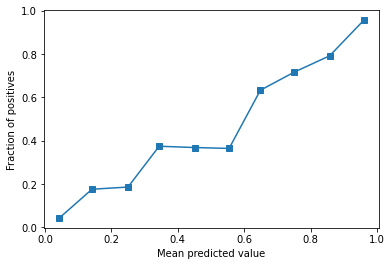

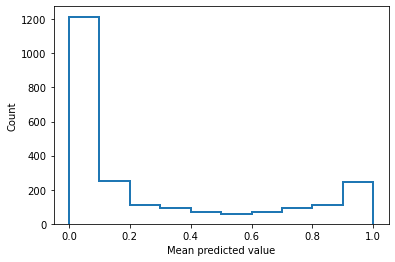

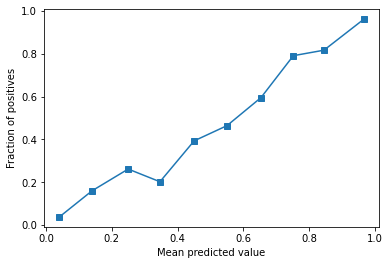

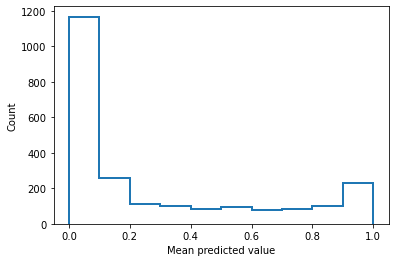

ROC AUC: 0.9129182900042867
Average Precision: 0.8370430700313273
Accuracy: 0.8716948417858691
ROC AUC: 0.915302083056718
Average Precision: 0.842453181064294
Accuracy: 0.8716948417858691

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 16.0

Probability threshold: 0.5
Score threshold: 47.0

Probability threshold: 0.9
Score threshold: 79.0



In [9]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel')

In [10]:
explainer.variables

array(['time2bg_24hr_flag', 'edvital_sbp_min', 'edvital_resprate_max',
       'fbc24hr_wbc_first', 'edvital_sbp_median', 'antibiotic_a_lesse1',
       'fbc24hr_platelet_first', 'edvital_resprate_median',
       'chem24hr_glucose_first', 'edvital_heartrate_median'], dtype=object)

In [11]:
explainer.score_array_list

[array([-5., 27.]),
 array([10., -3.,  2.]),
 array([ 3., -2.,  5.]),
 array([-3.,  4.]),
 array([ 4., -3.]),
 array([-2.,  9.]),
 array([ 3., -2.,  1., -1.,  2., -1.,  3.]),
 array([ 0., -0.,  1., -2.,  3.]),
 array([-2.,  2.]),
 array([10., -1.,  5.])]

In [12]:
explainer.breakpoints_list

[[0.0, 0.17403243617429426, 1.0],
 [4.0, 96.01549345593047, 197.0461566172937, 202.0],
 [12.0, 14.996426305180512, 23.389887066693152, 165.0],
 [0.1, 10.183827378969612, 216.3],
 [10.0, 118.62804264583501, 212.0],
 [0.0, 0.16782224115520802, 1.0],
 [5.0,
  181.22964146043333,
  693.0366957035126,
  767.2137195599691,
  815.631330835852,
  898.6679853050094,
  960.6078731114176,
  1496.0],
 [9.5,
  9.940846871377582,
  10.929738912120895,
  14.232707225888706,
  18.82135267689515,
  62.0],
 [15.0, 109.38075709882479, 1027.0],
 [39.0, 48.85140540079688, 103.67653322969102, 174.0]]

In [13]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))

ROC AUC: 0.8854242933502273
Average Precision: 0.789823223132849
Accuracy: 0.8513220632856524
[[1602   77]
 [ 266  362]]


In [15]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [17]:
y_test = y_test.reset_index(drop=True)

In [18]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.8798351090816844, 0.8711191794618366, 0.8885510387015322)
(0.7752160314204036, 0.7617252230817012, 0.788706839759106)
(0.846, 0.8404928089954103, 0.8515071910045896)
